In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy import array
import scipy as sp
import scipy.stats as sps
from scipy.stats import norm
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import os

In [17]:
SPX_EuCallOpt = pd.read_csv("SPX_Options_Cleaned_199001_201803.csv",sep=";")
SPX_EuCallOpt.head()

,IVol,day,maturity,month,price,stock,strike,type,year
0,0.1345,3,17,1,4.125,358.76,360,1,1990
1,0.2023,3,17,1,1.188,358.76,345,2,1990
2,0.1789,3,17,1,1.813,358.76,350,2,1990
3,0.1645,3,17,1,2.813,358.76,355,2,1990
4,0.1566,3,17,1,4.625,358.76,360,2,1990


In [18]:
base = SPX_EuCallOpt

Day = base["day"]
Month = base["month"]
Year = base["year"]

IVol = base["IVol"]
Strike = base["strike"]
Price = base["price"]
Stock = base["stock"]

Type = base["type"]

base["Moneyness"] = base["strike"] / base["stock"]

In [19]:
## 1) ## Classify options by Moneyness

classification = [
    (base['type'] == 1) & (base["Moneyness"] > 1.015), #OTM Call 
    (base['type'] == 1) & (base["Moneyness"] >= 0.985) & (base["Moneyness"] <= 1.015), #ATM Call
    (base['type'] == 1) & (base["Moneyness"]< 0.985), #ITM Call
        
    (base['type'] == 2) & (base["Moneyness"] > 1.015), #OTM Put
    (base['type'] == 2) & (base["Moneyness"] >= 0.985) & (base["Moneyness"] <= 1.015),#ATM Put
    (base['type'] == 2) & (base["Moneyness"] < 0.985), #ITM Put
    ]

# create a list of the values we want to assign for each condition
values = [-1, 0, 1, 1, 0, -1]

# create a new column and use np.select to assign values to it using our lists as arguments
base["Moneyness"] = np.select(classification, values)

# display updated DataFrame
base.head()
    

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness
0,0.1345,3,17,1,4.125,358.76,360,1,1990,0
1,0.2023,3,17,1,1.188,358.76,345,2,1990,-1
2,0.1789,3,17,1,1.813,358.76,350,2,1990,-1
3,0.1645,3,17,1,2.813,358.76,355,2,1990,0
4,0.1566,3,17,1,4.625,358.76,360,2,1990,0


In [21]:
#Create a df for each type & moneyness option
CallOTM = base[(base['type'] == 1) & (base['Moneyness'] == -1)].copy()
CallOTM['Count'] = 1
NbrCallOTMpermonth = CallOTM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

CallATM = base[(base['type'] == 1) & (base['Moneyness'] == 0)].copy()
CallATM['Count'] = 1
NbrCallATMpermonth = CallATM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

CallITM = base[(base['type'] == 1) & (base['Moneyness'] == 1)].copy()
CallITM['Count'] = 1
NbrCallITMpermonth = CallITM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

PutOTM = base[(base['type'] == 2) & (base['Moneyness'] == -1)].copy()
PutOTM['Count'] = 1
NbrPutOTMpermonth = PutOTM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

PutATM = base[(base['type'] == 2) & (base['Moneyness'] == 0)].copy()
PutATM['Count'] = 1
NbrPutATMpermonth = PutATM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

PutITM = base[(base['type'] == 2) & (base['Moneyness'] == 1)].copy()
PutITM['Count'] = 1
NbrPutITMpermonth = PutITM.groupby(['year', 'month'])['Count'].sum().reset_index(name='Count')

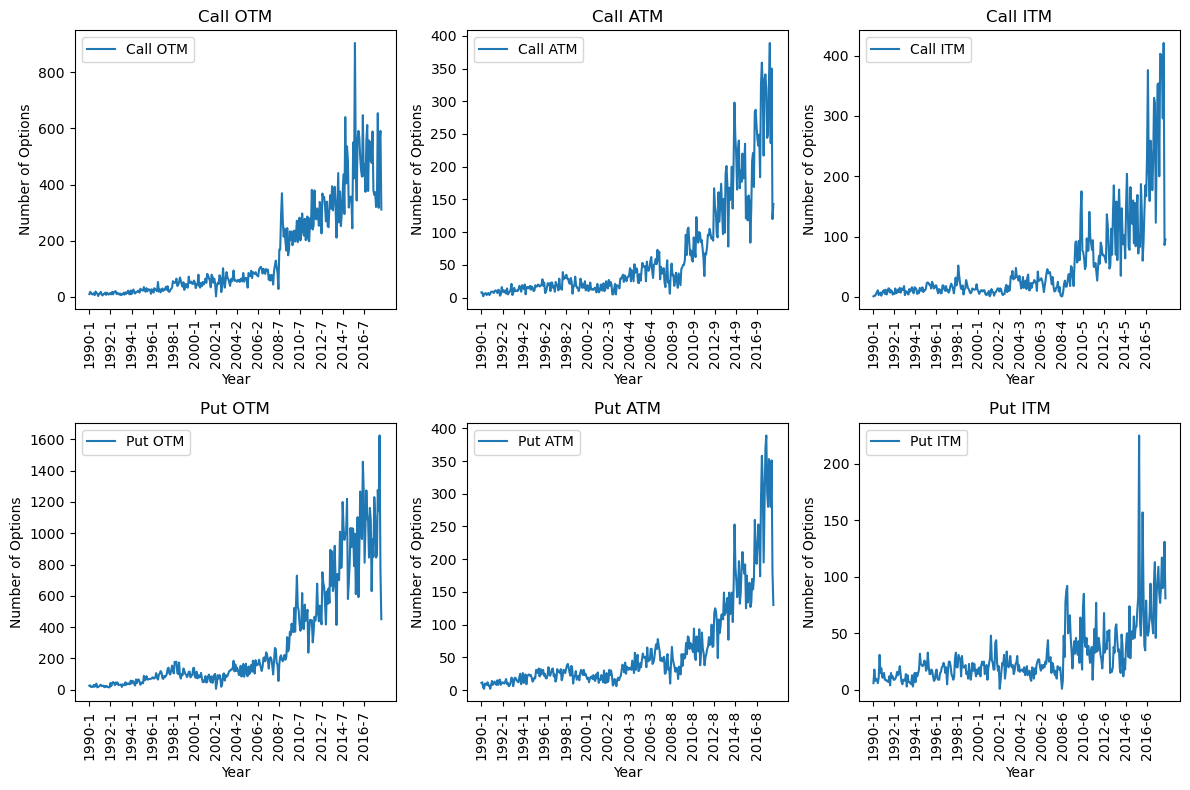

In [22]:
#Extract only the year from the combined 'year-month' column
NbrCallOTMpermonth['Date'] = NbrCallOTMpermonth['year'].astype(str) + '-' + NbrCallOTMpermonth['month'].astype(str)
NbrCallATMpermonth['Date'] = NbrCallATMpermonth['year'].astype(str) + '-' + NbrCallATMpermonth['month'].astype(str)
NbrCallITMpermonth['Date'] = NbrCallITMpermonth['year'].astype(str) + '-' + NbrCallITMpermonth['month'].astype(str)
NbrPutOTMpermonth['Date'] = NbrPutOTMpermonth['year'].astype(str) + '-' + NbrPutOTMpermonth['month'].astype(str)
NbrPutATMpermonth['Date'] = NbrPutATMpermonth['year'].astype(str) + '-' + NbrPutATMpermonth['month'].astype(str)
NbrPutITMpermonth['Date'] = NbrPutITMpermonth['year'].astype(str) + '-' + NbrPutITMpermonth['month'].astype(str)

#Plot each time series separately
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(NbrCallOTMpermonth['Date'], NbrCallOTMpermonth['Count'], label='Call OTM')
plt.title('Call OTM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrCallOTMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(NbrCallATMpermonth['Date'], NbrCallATMpermonth['Count'], label='Call ATM')
plt.title('Call ATM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrCallATMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(NbrCallITMpermonth['Date'], NbrCallITMpermonth['Count'], label='Call ITM')
plt.title('Call ITM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrCallITMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(NbrPutOTMpermonth['Date'], NbrPutOTMpermonth['Count'], label='Put OTM')
plt.title('Put OTM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrPutOTMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(NbrPutATMpermonth['Date'], NbrPutATMpermonth['Count'], label='Put ATM')
plt.title('Put ATM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrPutATMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(NbrPutITMpermonth['Date'], NbrPutITMpermonth['Count'], label='Put ITM')
plt.title('Put ITM')
plt.xlabel('Year')
plt.ylabel('Number of Options')
plt.xticks(NbrPutITMpermonth['Date'][::24], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


###### 2) ## Avg Option Volatility per maturity by Moneyness

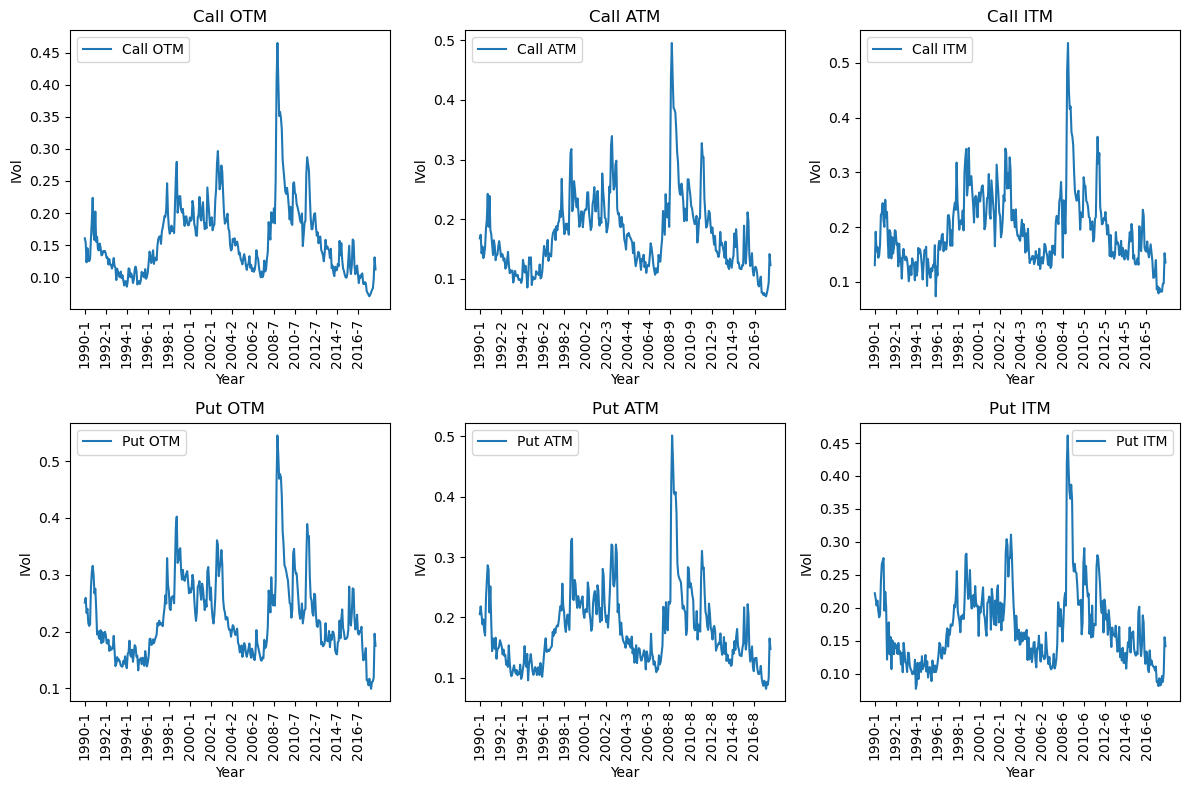

In [24]:
CallOTMAvgIVolpermonth = CallOTM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')
CallATMAvgIVolpermonth = CallATM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')
CallITMAvgIVolpermonth = CallITM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')
PutOTMAvgIVolpermonth = PutOTM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')
PutATMAvgIVolpermonth = PutATM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')
PutITMAvgIVolpermonth = PutITM.groupby(['year','month'])['IVol'].mean().reset_index(name='IVol')

#Extract only the year from the combined 'year-month' column
CallOTMAvgIVolpermonth['Date'] = NbrCallOTMpermonth['year'].astype(str) + '-' + NbrCallOTMpermonth['month'].astype(str)
CallATMAvgIVolpermonth['Date'] = NbrCallATMpermonth['year'].astype(str) + '-' + NbrCallATMpermonth['month'].astype(str)
CallITMAvgIVolpermonth['Date'] = NbrCallITMpermonth['year'].astype(str) + '-' + NbrCallITMpermonth['month'].astype(str)
PutOTMAvgIVolpermonth['Date'] = NbrPutOTMpermonth['year'].astype(str) + '-' + NbrPutOTMpermonth['month'].astype(str)
PutATMAvgIVolpermonth['Date'] = NbrPutATMpermonth['year'].astype(str) + '-' + NbrPutATMpermonth['month'].astype(str)
PutITMAvgIVolpermonth['Date'] = NbrPutITMpermonth['year'].astype(str) + '-' + NbrPutITMpermonth['month'].astype(str)

#Plot each time series separately
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(CallOTMAvgIVolpermonth['Date'], CallOTMAvgIVolpermonth['IVol'], label='Call OTM')
plt.title('Call OTM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(CallOTMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(CallATMAvgIVolpermonth['Date'], CallATMAvgIVolpermonth['IVol'], label='Call ATM')
plt.title('Call ATM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(CallATMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(CallITMAvgIVolpermonth['Date'], CallITMAvgIVolpermonth['IVol'], label='Call ITM')
plt.title('Call ITM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(CallITMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(PutOTMAvgIVolpermonth['Date'], PutOTMAvgIVolpermonth['IVol'], label='Put OTM')
plt.title('Put OTM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(PutOTMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(PutATMAvgIVolpermonth['Date'], PutATMAvgIVolpermonth['IVol'], label='Put ATM')
plt.title('Put ATM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(PutATMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(PutITMAvgIVolpermonth['Date'], PutITMAvgIVolpermonth['IVol'], label='Put ITM')
plt.title('Put ITM')
plt.xlabel('Year')
plt.ylabel('IVol')
plt.xticks(PutITMAvgIVolpermonth['Date'][::24], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

##### 3) ## Focusing on February 2018

##### a) Scatter plots of IV against moneyness by option type #

In [30]:
years = np.array([str(Year[i])[0:4] for i in range(0,len(Year))])
month = np.array([str(base['month'][i])[0:2] for i in range(len(base))])

df_feb18 = base[(years == '2018') & (month == '2')].copy()

call_df_feb18 = df_feb18[df_feb18["type"]==1]
put_df_feb18 = df_feb18[df_feb18["type"]==2]

# Call & Put: IV vs Moneyness
call_df_feb18["Moneyness"] = call_df_feb18["stock"] / call_df_feb18["strike"]
put_df_feb18["Moneyness"] = put_df_feb18["stock"] / put_df_feb18["strike"]


/var/folders/_5/1cyvh6h96znfqjfg9t3f55nh0000gp/T/ipykernel_76004/3247607877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_df_feb18["Moneyness"] = call_df_feb18["stock"] / call_df_feb18["strike"]
/var/folders/_5/1cyvh6h96znfqjfg9t3f55nh0000gp/T/ipykernel_76004/3247607877.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_df_feb18["Moneyness"] = put_df_feb18["stock"] / put_df_feb18["strike"]


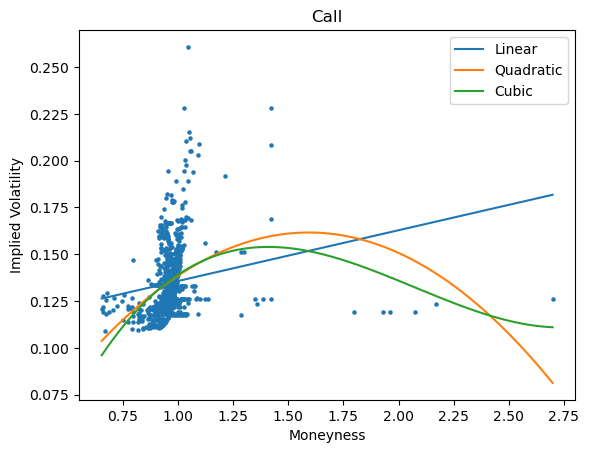

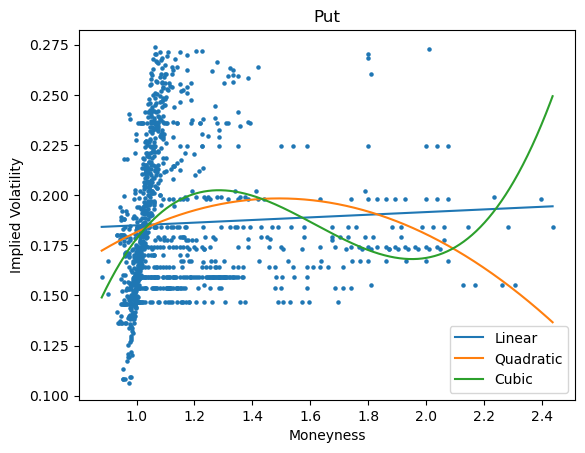

In [32]:
def plot_scatter(option_dataframes, titles):
    for i, (option_df, title) in enumerate(zip(option_dataframes, titles)):
        # Extract x and y data
        x = option_df['Moneyness']
        y = option_df['IVol']

        # Scatter plot
        plt.scatter(x, y, s=5)

        # Fit polynomial curves
        line = np.linspace(min(x), max(x), len(x))
        z1 = np.poly1d(np.polyfit(x, y, 1))
        z2 = np.poly1d(np.polyfit(x, y, 2))
        z3 = np.poly1d(np.polyfit(x, y, 3))

        # Plot polynomial curves
        plt.plot(line, z1(line), label="Linear")
        plt.plot(line, z2(line), label="Quadratic")
        plt.plot(line, z3(line), label="Cubic")

        # Customize the plot
        plt.legend()
        plt.title(title)
        plt.xlabel("Moneyness")
        plt.ylabel("Implied Volatility")
        plt.show()

Optiondataframes = [call_df_feb18, put_df_feb18]
Option_type = ["Call", "Put"]
plot_scatter(Optiondataframes, Option_type)

###### b)  Deterministric Volatility Function (DVF) estimation by OLS and RMSE / by option type (February 2018)

In [159]:
basedvf_Call = df_feb18[df_feb18["type"]==1] # Option type 1 : Call ; 2 : Put
basedvf_Call

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness
215827,0.1682,7,9,2,93.40,2681.7,2600,1,2018,1
215828,0.1682,7,9,2,52.70,2681.7,2650,1,2018,0
215829,0.1682,7,9,2,26.00,2681.7,2690,1,2018,0
215830,0.1665,7,9,2,3.75,2681.7,2770,1,2018,-1
215831,0.1665,7,9,2,3.80,2681.7,2775,1,2018,-1
...,...,...,...,...,...,...,...,...,...,...
217689,0.1334,28,92,2,50.60,2713.8,2775,1,2018,-1
217690,0.1128,28,92,2,5.70,2713.8,2950,1,2018,-1
217698,0.1264,28,205,2,292.20,2713.8,2500,1,2018,1
217700,0.1332,28,296,2,66.50,2713.8,2900,1,2018,-1


In [160]:
#Deterministic volatility function (DVF) by OLS for Call Option

K = basedvf_Call['strike']/1.0
tau = basedvf_Call['maturity']/365
y = basedvf_Call['IVol']

CallPrice = basedvf_Call['price']
S = basedvf_Call['stock']
r = 0.05

#OLS
X = np.array([np.ones((len(K))), ((K/S)-1), ((K/S)-1)**2, ((K/S)-1)**3, ((K/S)-1)*abs(((K/S)-1))]).transpose();

mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:                   IVol   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     44.92
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           5.06e-34
Time:                        15:20:43   Log-Likelihood:                 2087.0
No. Observations:                 797   AIC:                            -4164.
Df Residuals:                     792   BIC:                            -4141.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1428      0.001    156.996      0.0

In [161]:
coefols_call = res.params
coefols_call.values

array([ 0.1428386 , -0.2402566 , -0.08050298, -0.80345636,  0.87358841])

In [162]:
#Black Scholes Model for Option pricing formula

def BScallPrice(sigma,K,tau,S,r):
    d1 = (np.log(S/K) + (r+(1/2)*sigma**2)*tau) / (sigma*np.sqrt(tau));
    d2 = d1 - sigma*np.sqrt(tau);
    BSc = S*sps.norm.cdf(d1) - K*np.exp(-r*tau)*sps.norm.cdf(d2);
    return BSc


def BSputPrice(sigma,K,tau,S,r):
    d1 = (np.log(S/K) + (r+(1/2)*sigma**2)*tau) / (sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    c = S*sps.norm.cdf(d1) - K*np.exp(-r*tau)*sps.norm.cdf(d2);
    BSp = c+K*np.exp(-r*tau)-S;
    return BSp

#PBS Call Option Pricing

def PBScallPrice(param,K,tau,S,r):
    a0 = param[0];
    a1 = param[1];
    a2 = param[2];
    a3 = param[3];
    a4 = param[4];
    sigma = a0 + a1*((K/S)-1) + a2*((K/S)-1)**2 + a3*((K/S)-1)**3 + a4*(K/S-1)*abs((K/S-1)); #Deterministic Vol. Function
    PBSc = BScallPrice(sigma,K,tau,S,r)
    return PBSc


def PBSputPrice(param,K,tau,S,r):
    a0 = param[0];
    a1 = param[1];
    a2 = param[2];
    a3 = param[3];
    a4 = param[4];
    sigma = a0 + a1*((K/S)-1) + a2*((K/S)-1)**2 + a3*((K/S)-1)**3 + a4*(K/S-1)*abs((K/S-1)); #Deterministic Vol. Function
    PBSp = BSputPrice(sigma,K,tau,S,r)
    return PBSp

In [163]:
#RMSE
bounds = [(-17,17), (-17,17),(-17,17), (-17,17),(-17,17)]

K = basedvf_Call['strike'].values
tau = basedvf_Call['maturity'].values/365
y = basedvf_Call['IVol'].values

CallPrice = basedvf_Call['price'].values
S = basedvf_Call['stock'].values
r = 0.05

def PBS_sigma_c(param):
    return np.sqrt(np.mean((PBScallPrice(param,K,tau,S,r) - CallPrice)**2))

result = sp.optimize.differential_evolution(PBS_sigma_c, bounds)
coefoptim_call = result.x
coefoptim_call

array([ 0.10500261, -0.06207291, -0.14867744, -0.01891399,  0.19053791])

In [164]:
p_ols = PBScallPrice(coefols_call.values,K,tau,S,r)
p_optim = PBScallPrice(coefoptim_call,K,tau,S,r)

print(pd.DataFrame([coefols_call.values, coefoptim_call]))

          0         1         2         3         4
0  0.142839 -0.240257 -0.080503 -0.803456  0.873588
1  0.105003 -0.062073 -0.148677 -0.018914  0.190538


In [165]:
print(f"RMSE from OLS method for Call Option: {np.sqrt(np.mean((CallPrice-p_ols)**2))}")
print(f"RMSE from Optimisation method for Call Option: {np.sqrt(np.mean((CallPrice-p_optim)**2))}")

RMSE from OLS method for Call Option: 13.884098627280272
RMSE from Optimisation method for Call Option: 7.491640446768842


In [166]:
#Deterministic volatility function (DVF) by OLS for Put Option

basedvf_Put = df_feb18[df_feb18["type"]==2] # Option type 1 : Call ; 2 : Put
basedvf_Put

,IVol,day,maturity,month,price,stock,strike,type,year,Moneyness
215842,0.2360,7,9,2,1.25,2681.7,1925,2,2018,-1
215843,0.2360,7,9,2,2.85,2681.7,2200,2,2018,-1
215844,0.2360,7,9,2,3.50,2681.7,2255,2,2018,-1
215845,0.2360,7,9,2,4.50,2681.7,2350,2,2018,-1
215846,0.2360,7,9,2,6.65,2681.7,2425,2,2018,-1
...,...,...,...,...,...,...,...,...,...,...
217699,0.1952,28,205,2,66.40,2713.8,2500,2,2018,-1
217702,0.1551,28,296,2,2.01,2713.8,1175,2,2018,-1
217703,0.1551,28,296,2,3.00,2713.8,1250,2,2018,-1
217704,0.1551,28,296,2,3.00,2713.8,1275,2,2018,-1


In [167]:
K = basedvf_Put['strike']/1.0
tau = basedvf_Put['maturity']/365
y = basedvf_Put['IVol']

PutPrice = basedvf_Put['price']
S = basedvf_Put['stock']
r = 0.05

#OLS
X = np.array([np.ones((len(K))), ((K/S)-1), ((K/S)-1)**2, ((K/S)-1)**3, ((K/S)-1)*abs(((K/S)-1))]).transpose();

mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

coefols_put = res.params
coefols_put.values

                            OLS Regression Results                            
Dep. Variable:                   IVol   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     69.29
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           3.09e-52
Time:                        15:20:49   Log-Likelihood:                 2206.4
No. Observations:                1082   AIC:                            -4403.
Df Residuals:                    1077   BIC:                            -4378.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1726      0.002    111.807      0.0

array([ 0.17258197, -0.59496817,  1.03173812, -3.77037211,  4.06558928])

In [168]:
#RMSE
bounds = [(-17,17), (-17,17),(-17,17), (-17,17),(-17,17)]

K = basedvf_Put['strike'].values
tau = basedvf_Put['maturity'].values/365
y = basedvf_Put['IVol'].values

PutPrice = basedvf_Put['price'].values
S = basedvf_Put['stock'].values
r = 0.05

def PBS_sigma_p(param):
    return np.sqrt(np.mean((PBSputPrice(param,K,tau,S,r) - PutPrice)**2))

result = sp.optimize.differential_evolution(PBS_sigma_p, bounds)
coefoptim_put = result.x
coefoptim_put

array([ 0.19223212, -0.67185736,  3.47397978, -1.45308073,  5.06006963])

In [169]:
p_ols = PBSputPrice(coefols_put.values,K,tau,S,r)
p_optim = PBSputPrice(coefoptim_put,K,tau,S,r)

print(pd.DataFrame([coefols_put.values, coefoptim_put]))

          0         1         2         3         4
0  0.172582 -0.594968  1.031738 -3.770372  4.065589
1  0.192232 -0.671857  3.473980 -1.453081  5.060070


In [170]:
print(f"RMSE from OLS method for Put Option: {np.sqrt(np.mean((PutPrice-p_ols)**2))}")
print(f"RMSE from Optimisation method for Put Option: {np.sqrt(np.mean((PutPrice-p_optim)**2))}")

RMSE from OLS method for Put Option: 14.133631988690597
RMSE from Optimisation method for Put Option: 6.456259332767516


In [ ]:
###### b)  Deterministric Volatility Function (DVF) estimation by OLS and RMSE / by option type (March 2018)

In [174]:
df_march18 = base[(years == '2018') & (month == '3')].copy()
basedvf_Call = df_march18[df_march18["type"]==1] # Option type 1 : Call ; 2 : Put
basedvf_Call

#For Call Option

K = basedvf_Call['strike'].values
tau = basedvf_Call['maturity'].values/365
y = basedvf_Call['IVol'].values

CallPrice = basedvf_Call['price'].values
S = basedvf_Call['stock'].values
r = 0.05

p_ols = PBScallPrice(coefols_call.values,K,tau,S,r)
p_optim = PBScallPrice(coefoptim_call,K,tau,S,r)

print(f"RMSE from OLS method for Call Option: {np.sqrt(np.mean((CallPrice-p_ols)**2))}")
print(f"RMSE from Optimisation method for Call Option: {np.sqrt(np.mean((CallPrice-p_optim)**2))}")

RMSE from OLS method for Call Option: 17.078722897871014
RMSE from Optimisation method for Call Option: 146.85167759611193


In [175]:
df_march18 = base[(years == '2018') & (month == '3')].copy()
basedvf_Put = df_march18[df_march18["type"]==2] # Option type 1 : Call ; 2 : Put
basedvf_Put

#For Call Option

K = basedvf_Put['strike'].values
tau = basedvf_Put['maturity'].values/365
y = basedvf_Put['IVol'].values

PutPrice = basedvf_Put['price'].values
S = basedvf_Put['stock'].values
r = 0.05

p_ols = PBSputPrice(coefols_put.values,K,tau,S,r)
p_optim = PBSputPrice(coefoptim_put,K,tau,S,r)

print(f"RMSE from OLS method for Put Option: {np.sqrt(np.mean((PutPrice-p_ols)**2))}")
print(f"RMSE from Optimisation method for Put Option: {np.sqrt(np.mean((PutPrice-p_optim)**2))}")

RMSE from OLS method for Put Option: 17.26017573835742
RMSE from Optimisation method for Put Option: 16.029128639133013
